In [20]:
import numpy as np
################################################################################
# CIFAR i MNIST - na samym dole jak użyć tych funkcji
################################################################################

EVT_DVS = 0  # DVS event type
EVT_APS = 1  # APS event

def read_bits(arr, mask=None, shift=None):
    if mask is not None:
        arr = arr & mask
    if shift is not None:
        arr = arr >> shift
    return arr


y_mask = 0x7FC00000
y_shift = 22

x_mask = 0x003FF000
x_shift = 12

polarity_mask = 0x800
polarity_shift = 11

valid_mask = 0x80000000
valid_shift = 31


def skip_header(fp):
    p = 0
    lt = fp.readline()
    ltd = lt.decode().strip()
    while ltd and ltd[0] == "#":
        p += len(lt)
        lt = fp.readline()
        try:
            ltd = lt.decode().strip()
        except UnicodeDecodeError:
            break
    return p


def load_raw_events(fp,
                    bytes_skip=0,
                    bytes_trim=0,
                    filter_dvs=False,
                    times_first=False):
    p = skip_header(fp)
    fp.seek(p + bytes_skip)
    data = fp.read()
    if bytes_trim > 0:
        data = data[:-bytes_trim]
    data = np.fromstring(data, dtype='>u4')
    if len(data) % 2 != 0:
        print(data[:20:2])
        print('---')
        print(data[1:21:2])
        raise ValueError('odd number of data elements')
    raw_addr = data[::2]
    timestamp = data[1::2]
    if times_first:
        timestamp, raw_addr = raw_addr, timestamp
    if filter_dvs:
        valid = read_bits(raw_addr, valid_mask, valid_shift) == EVT_DVS
        timestamp = timestamp[valid]
        raw_addr = raw_addr[valid]
    return timestamp, raw_addr


def parse_raw_address(addr,
                      x_mask=x_mask,
                      x_shift=x_shift,
                      y_mask=y_mask,
                      y_shift=y_shift,
                      polarity_mask=polarity_mask,
                      polarity_shift=polarity_shift):
    polarity = read_bits(addr, polarity_mask, polarity_shift).astype(np.bool_)
    x = read_bits(addr, x_mask, x_shift)
    y = read_bits(addr, y_mask, y_shift)
    return x, y, polarity


def load_events(
        fp,
        filter_dvs=False,
        **kwargs):
    timestamp, addr = load_raw_events(
        fp,
        filter_dvs=filter_dvs,
    )
    x, y, polarity = parse_raw_address(addr, **kwargs)
    return timestamp, x, y, polarity





In [21]:
import os

import argparse
import pickle as pkl
from Dataset import Dataset
from model import *
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

C:\Users\nikos\AppData\Local\Temp\ipykernel_1632\1512634125.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')


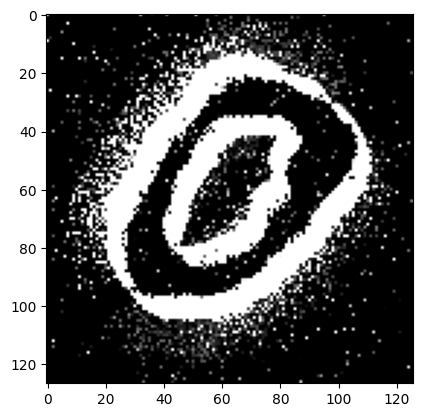

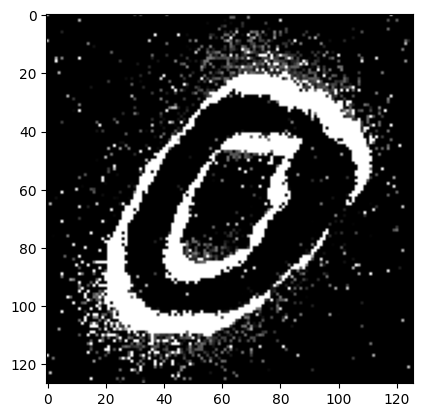

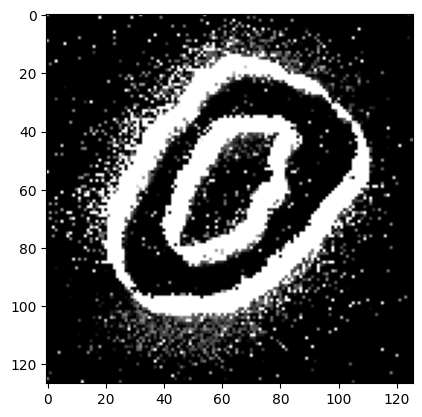

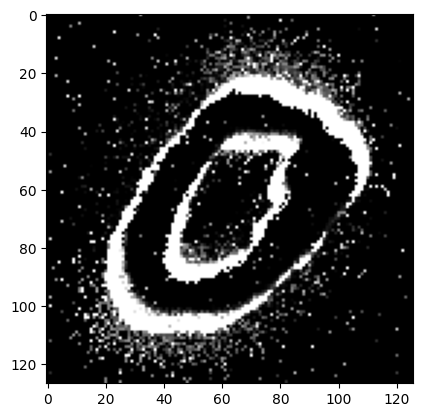

126 127


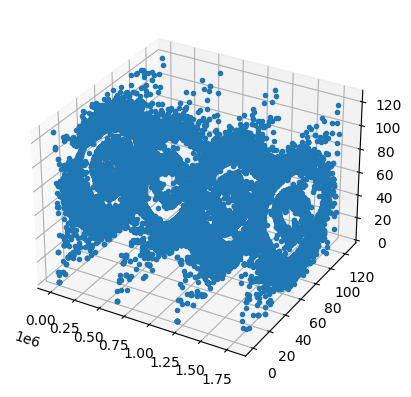

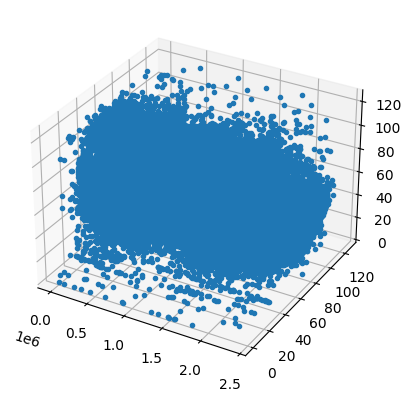

In [22]:
tau = 0.8
alpha = 0.1
# Jak użyć funckji:
event_file = "Datasety/NMINST/grabbed_data0/grabbed_data0/scale16/mnist_0_scale16_0001.aedat"
with open(event_file, 'rb') as fp:
    t, x, y, p = load_events(fp,
                x_mask=0xfE,
                x_shift=1,
                y_mask=0x7f00,
                y_shift=8,
                polarity_mask=1,
                polarity_shift=None)

    events = {'t': t, 'x': 127 - y, 'y': 127 - x, 'p': 1 - p.astype(int)}

    noBins = 4
    pic = np.zeros((noBins*2,128,128))
    pic3D = []
    pic3D_quantized = []
    temp_x = 0   
    temp_y = 0
    delta_t = (np.max(t)+0.00001)/noBins
    for event in range(len(events['t'])):
        t,x,y,p = events['t'][event], events["x"][event],events["y"][event],events["p"][event]
        temp_x = max(temp_x, x)
        temp_y = max(temp_y, y)
        for i in range(int(np.floor(float(t)/delta_t)), min(int(np.floor(float(t)/delta_t))+1, noBins)):
            pic[i,y,x] = min(pic[i,y,x] + max(0,1-abs((((i+1)*delta_t)-t)/(delta_t))), 1)
        
        pic3D_quantized.append([int(np.floor(float(t)/delta_t)) * delta_t,x,y])
        pic3D.append([t,x,y])
    
    pic = np.array(pic)
    for i in range(noBins):
        pic2 = pic[i,:temp_y,:temp_x]
        plt.gray()
        plt.imshow(pic2)
        plt.show()



    ax = plt.figure().add_subplot(projection='3d')
    pic3D_quantized = np.array(pic3D_quantized)
    ax.plot(pic3D_quantized[:,0], pic3D_quantized[:,1], pic3D_quantized[:,2], '.')


    ax = plt.figure().add_subplot(projection='3d')
    pic3D = np.array(pic3D)
    ax.plot(pic3D[:,0], pic3D[:,1], pic3D[:,2], '.')
    print(temp_x, temp_y)



In [23]:
import cv2

In [24]:
train_dir_c = "Datasety/NMINST/grabbed_data"

noBins = 4
tau = 0.8
alpha = 0.1
train_x = []
train_y = []

test_x = []
test_y = []
for number in [0,1,2,3,4,5,6,7,8,9]:
    for filename, _ in zip(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale16/"),tqdm(range(len(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale16/"))))):
        with open(train_dir_c+f"{number}/grabbed_data{number}/scale16/"+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

            events = {'t': t, 'x': 127 - y, 'y': 127 - x, 'p': 1 - p.astype(int)}

            noBins = 5
            pic = np.zeros((noBins,128,128))
            delta_t = (np.max(t)+0.00001)/noBins
            for event in range(len(events['t'])):
                t,x,y,p = events['t'][event], events["x"][event],events["y"][event],events["p"][event]
                for i in range(int(np.floor(float(t)/delta_t)), min(int(np.floor(float(t)/delta_t))+1, noBins)):
                    pic[i,y,x] = min(pic[i,y,x] + max(0,1-abs((((i+1)*delta_t)-t)/(delta_t))), 1)
            pic = np.array(pic)
            # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # normalized_image = np.transpose(normalized_image, (1,2, 0))
            train_x.append(pic)#np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1))
            train_y.append(number)
dir_dataset = "Datasety/"
np.save(dir_dataset + 'train_MNIST_Voxel1_trilinear_x_resolution.npy', train_x)
np.save(dir_dataset + 'train_MNIST_Voxel1_trilinear_y_resolution.npy', train_y)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_1632\1512634125.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [04:23<00:00,  3.78it/s]


In [25]:
train_dir_c = "Datasety/NMINST/grabbed_data"

noBins = 4
tau = 0.8
alpha = 0.1
train_x = []
train_y = []
print("8x8")
for number in [0,1,2,3,4,5,6,7,8,9]:
    for filename, _ in zip(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale8/"),tqdm(range(len(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale8/"))))):
        with open(train_dir_c+f"{number}/grabbed_data{number}/scale8/"+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

            events = {'t': t, 'x': 127 - y, 'y': 127 - x, 'p': 1 - p.astype(int)}

            noBins = 5
            pic = np.zeros((noBins,128,128))
            delta_t = (np.max(t)+0.00001)/noBins
            for event in range(len(events['t'])):
                t,x,y,p = events['t'][event], events["x"][event],events["y"][event],events["p"][event]
                for i in range(int(np.floor(float(t)/delta_t)), min(int(np.floor(float(t)/delta_t))+1, noBins)):
                    pic[i,y,x] = min(pic[i,y,x] + max(0,1-abs((((i+1)*delta_t)-t)/(delta_t))), 1)
            pic = np.array(pic)
            # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # normalized_image = np.transpose(normalized_image, (1,2, 0))
            train_x.append(pic)#np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1))
            train_y.append(number)
dir_dataset = "Datasety/"
np.save(dir_dataset + 'train_MNIST_Voxel2_trilinear_x_resolution.npy', train_x)
np.save(dir_dataset + 'train_MNIST_Voxel2_trilinear_y_resolution.npy', train_y)


8x8


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_1632\1512634125.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [02:11<00:00,  7.58it/s]


In [26]:
train_dir_c = "Datasety/NMINST/grabbed_data"

noBins = 4
tau = 0.8
alpha = 0.1
train_x = []
train_y = []
print("4x4")
for number in [0,1,2,3,4,5,6,7,8,9]:
    for filename, _ in zip(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale4/"),tqdm(range(len(os.listdir(train_dir_c+f"{number}/grabbed_data{number}/scale4/"))))):
        with open(train_dir_c+f"{number}/grabbed_data{number}/scale4/"+filename, 'rb') as fp:
            t, x, y, p = load_events(fp,
                        x_mask=0xfE,
                        x_shift=1,
                        y_mask=0x7f00,
                        y_shift=8,
                        polarity_mask=1,
                        polarity_shift=None)

            events = {'t': t, 'x': 127 - y, 'y': 127 - x, 'p': 1 - p.astype(int)}

            noBins = 5
            pic = np.zeros((noBins,128,128))
            delta_t = (np.max(t)+0.00001)/noBins
            for event in range(len(events['t'])):
                t,x,y,p = events['t'][event], events["x"][event],events["y"][event],events["p"][event]
                for i in range(int(np.floor(float(t)/delta_t)), min(int(np.floor(float(t)/delta_t))+1, noBins)):
                    pic[i,y,x] = min(pic[i,y,x] + max(0,1-abs((((i+1)*delta_t)-t)/(delta_t))), 1)
            pic = np.array(pic)
            # normalized_image = cv2.normalize(pic, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            # normalized_image = np.transpose(normalized_image, (1,2, 0))
            train_x.append(pic)#np.transpose(cv2.resize(normalized_image, (128, 128)),(2,0,1))
            train_y.append(number)
train_x = np.array(train_x)
train_y = np.array(train_y)
dir_dataset = "Datasety/"
np.save(dir_dataset + 'train_MNIST_Voxel3_trilinear_x_resolution.npy', train_x)
np.save(dir_dataset + 'train_MNIST_Voxel3_trilinear_y_resolution.npy', train_y)

4x4


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\nikos\AppData\Local\Temp\ipykernel_1632\1512634125.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data, dtype='>u4')
100%|█████████▉| 999/1000 [01:09<00:00, 14.28it/s]
